In [90]:
from src import *
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

pdb = "/Users/kebl8116-admin/Projects/origami/data/Chignolin/xtc/nvt_prod_1_protein.pdb"
xtc = "/Users/kebl8116-admin/Projects/origami/data/Chignolin/xtc/nvt_prod_1_protein.xtc"

contact_maps = contacts.get_contact_maps(top=pdb, traj=xtc, seq_sep=4)
unique_maps, frame_to_uid, inds = contacts.get_unique_maps(contact_maps)

U = int(np.max(frame_to_uid)) + 1
node_counts = np.bincount(frame_to_uid, minlength=U)

flat_bits, tri, Mbits = contacts.flatten_upper_bits(unique_maps)
ints, Mbits, tri = contacts.maps_to_upper_ints(unique_maps)
Gm, ints = graphs.build_contact_manifold_graph(ints, Mbits, method='auto')
edge_info = graphs.temporal_edge_counts(frame_to_uid, keep_self_loops=False)
G = graphs.merge_manifold_and_temporal(Gm, edge_info, node_counts)

start_node = int(frame_to_uid[0])
folded_node = int(np.argmax(np.bincount(frame_to_uid)))
path_m = nx.shortest_path(Gm, source=start_node, target=folded_node)

X_emb, labels, D = clustering.embed_and_cluster_by_hamming(ints,
                                 n_components=10,
                                 embed_method='mds',   # 'mds' or 'spectral'
                                 cluster_method='agglomerative',  # 'agglomerative' or 'hdbscan'
                                 n_clusters=None,      # only for agglomerative
                                 random_state=42,
                                 warn_threshold=4000)
pos = {i:(float(X_emb[i,0]), float(X_emb[i,1])) for i in range(X_emb.shape[0])}


Frames: 10001 N: 10 Unique maps: 207


/Users/kebl8116-admin/miniconda3/envs/folding_graphs/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
/Users/kebl8116-admin/miniconda3/envs/folding_graphs/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kebl8116-admin/miniconda3/envs/folding_graphs/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kebl8116-admin/miniconda3/envs/folding_graphs/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/kebl8116-admin/miniconda3/envs/folding_graphs/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kebl8116-admin/miniconda3/envs/folding_graphs/lib/python3.10/site-packages/skl

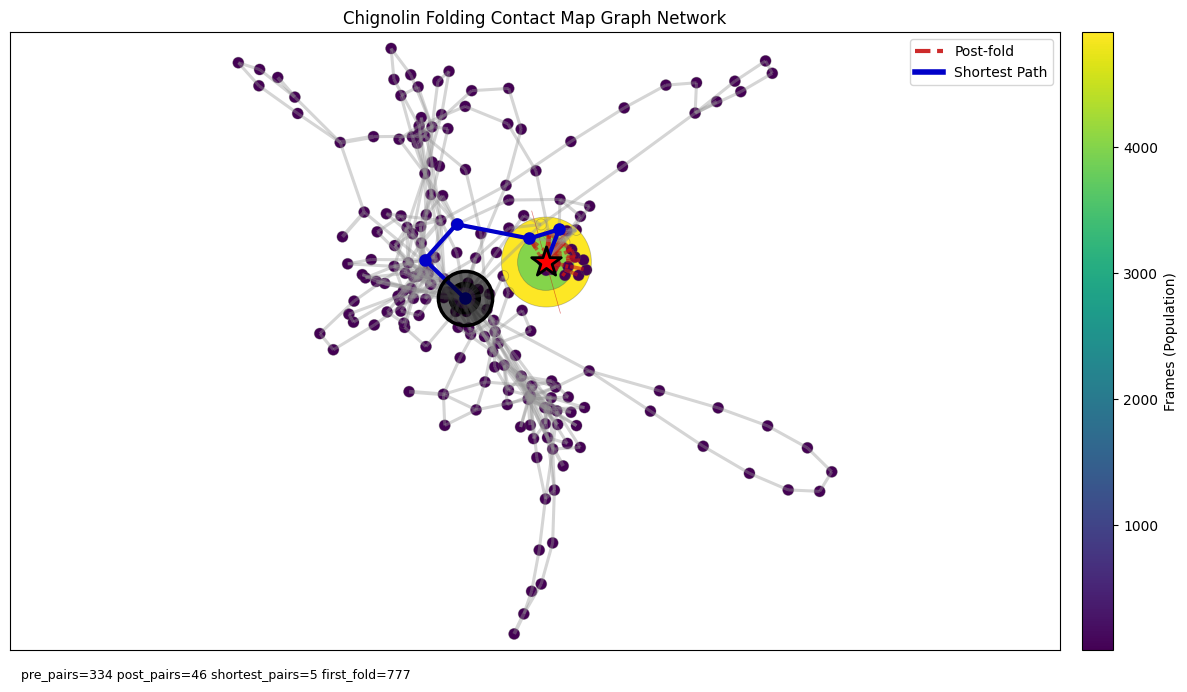

In [2]:
G, counter, node_counts = graphs.build_temporal_transition_graph(frame_to_uid, inds, keep_self_loops=False)
fig, ax = plotting.plot_graph_auto(G, frame_to_uid, unique_maps=unique_maps, unique_indices=inds, interactive=False, count_multiplicity=True,
                                   title="Chignolin Folding Contact Map Graph Network")
plt.savefig("images/chignolin_temporal_graph_seqsep.png", dpi=300)

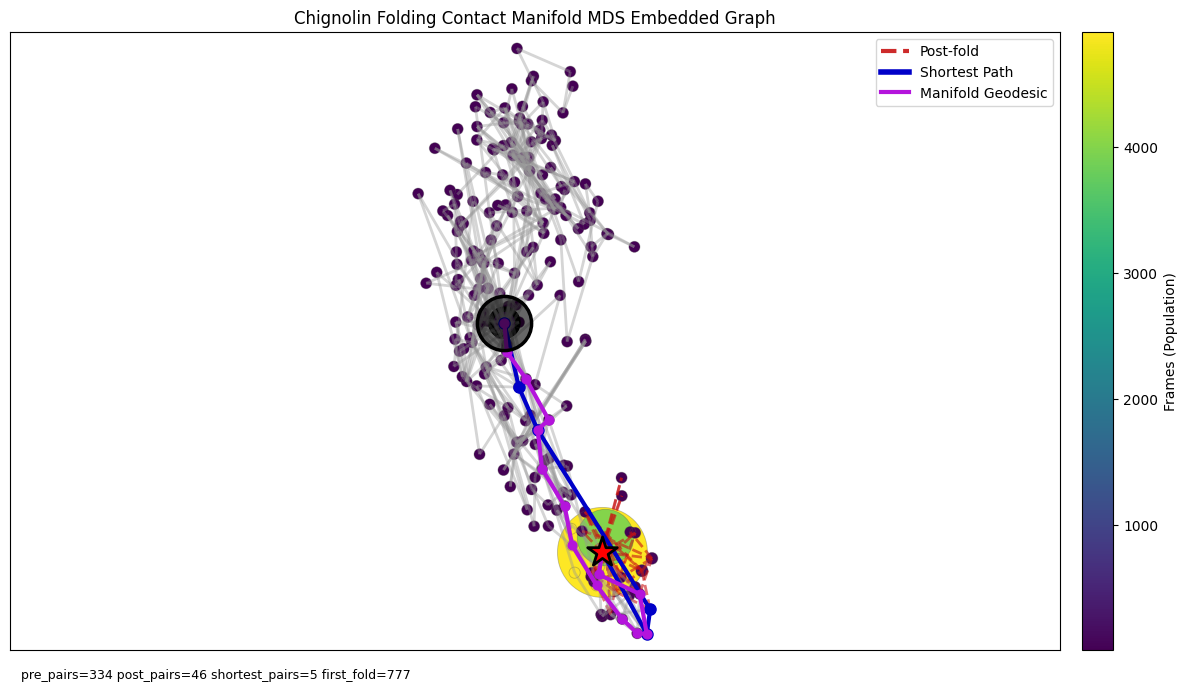

In [3]:
# custom path overlays
custom_paths = {
    'Manifold Geodesic': path_m
}
fig, ax = plotting.plot_graph_auto(G, frame_to_uid, pos, X_emb, unique_maps=unique_maps, unique_indices=inds, interactive=False,
                                   custom_paths=custom_paths,
                                   title="Chignolin Folding Contact Manifold MDS Embedded Graph")

/Users/kebl8116-admin/miniconda3/envs/folding_graphs/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


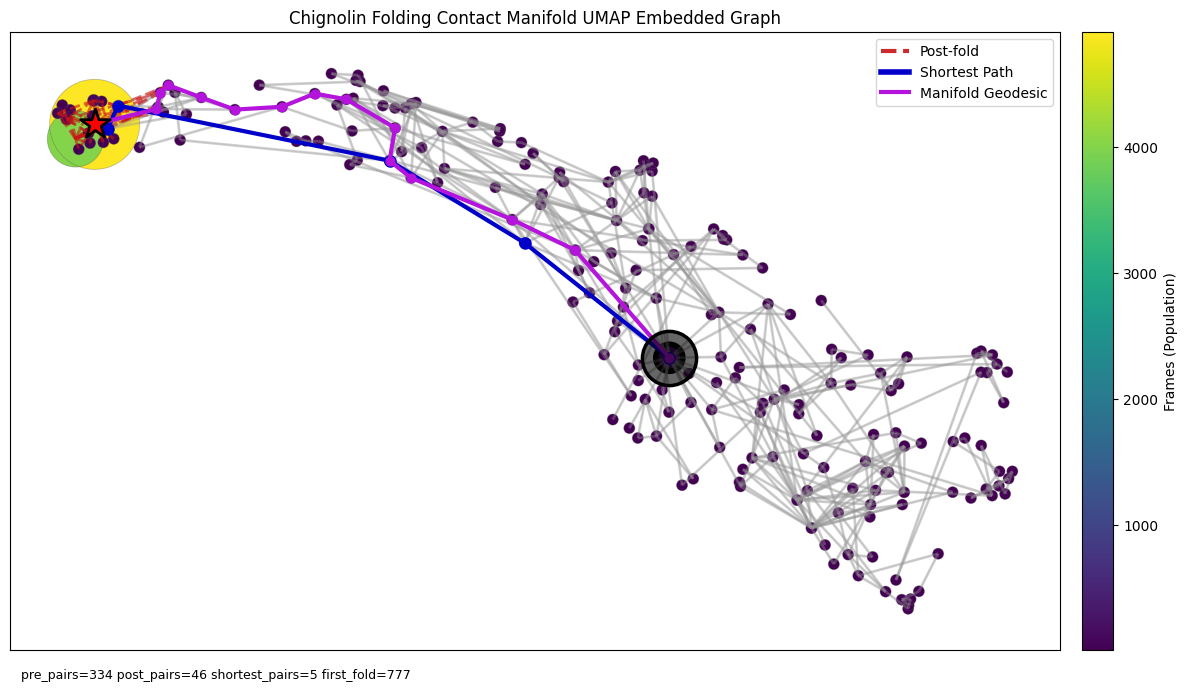

In [4]:
flat_bits, tri, Mbits = contacts.flatten_upper_bits(unique_maps)
ints, Mbits, tri = contacts.maps_to_upper_ints(unique_maps)
Gm, ints = graphs.build_contact_manifold_graph(ints, Mbits, method='auto')
edge_info = graphs.temporal_edge_counts(frame_to_uid, keep_self_loops=False)
G = graphs.merge_manifold_and_temporal(Gm, edge_info, node_counts=node_counts)

def embed_flat_bits(flat_bits, method='umap', n_components=2, n_neighbors=15, random_state=42):
    """
    embed flat_bits (U, Mbits) -> X_emb (U,2)
    Prefer UMAP if available, else Isomap, else SpectralEmbedding, else PCA.
    """
    U = flat_bits.shape[0]
    method = method.lower()
    X = flat_bits.astype(float)  # scikit-learn expects float arrays
    if method == 'umap' and _has_umap:
        reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, random_state=random_state)
        X_emb = reducer.fit_transform(X)
        return X_emb
    if method == 'isomap':
        iso = Isomap(n_components=n_components, n_neighbors=max(5, min(n_neighbors, U-1)))
        X_emb = iso.fit_transform(X)
        return X_emb
    if method == 'spectral':
        sp = SpectralEmbedding(n_components=n_components, n_neighbors=max(5, min(n_neighbors, U-1)))
        X_emb = sp.fit_transform(X)
        return X_emb
    # fallback PCA for extreme cases
    pca = PCA(n_components=n_components, random_state=random_state)
    X_emb = pca.fit_transform(X)
    return X_emb

_has_umap = True
import umap

X_emb = embed_flat_bits(flat_bits, method='umap', n_neighbors=15)
pos = {i:(float(X_emb[i,0]), float(X_emb[i,1])) for i in range(X_emb.shape[0])}

fig, ax = plotting.plot_graph_auto(G, frame_to_uid, pos, X_emb, unique_maps=unique_maps, unique_indices=inds, interactive=False, count_multiplicity=False,
                                   custom_paths=custom_paths,
                                   title="Chignolin Folding Contact Manifold UMAP Embedded Graph")

plt.savefig("images/chignolin_manifold_umap_graph_seqsep.png")

[(0, 0.32885403611874664), (117, 0.2409772815668754), (64, 0.1866786522831433), (188, 0.1693248321224081), (145, 0.147237334299582), (60, 0.1005975996741797), (160, 0.09880443010667468), (118, 0.09458673210676245), (2, 0.08438548340956266), (8, 0.08353859789499371)]


/var/folders/bd/1_0prvlx06lcc135mt668_3r0000gs/T/ipykernel_8329/328411396.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("viridis_r")


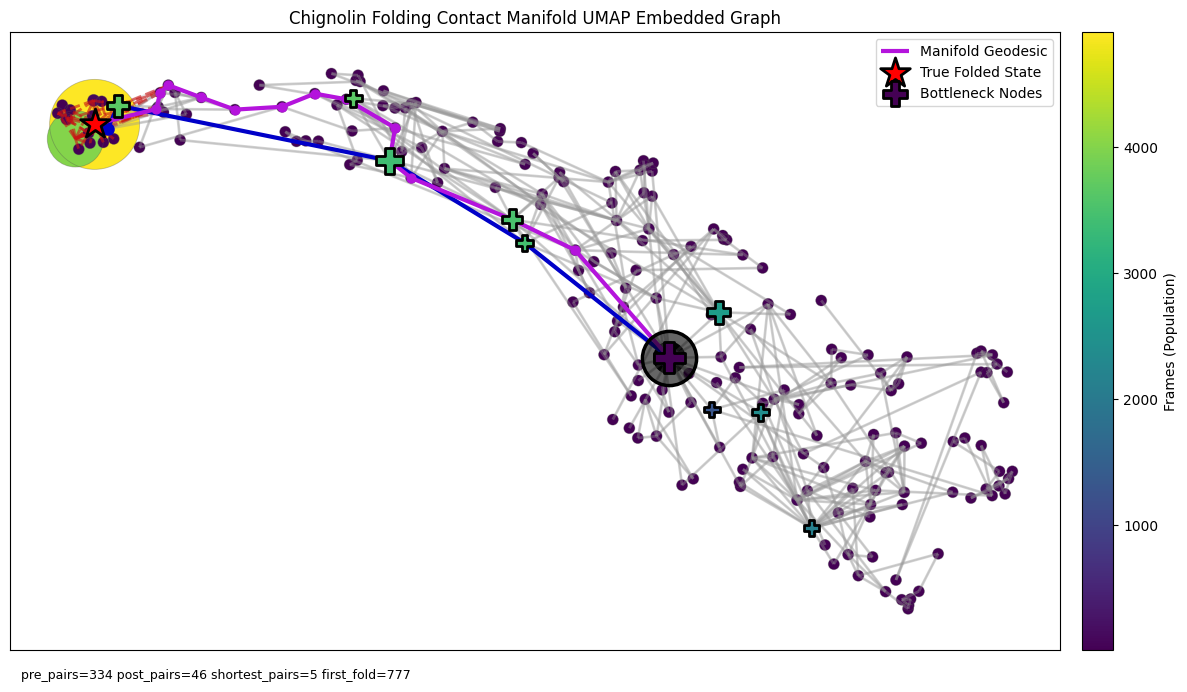

In [74]:
import networkx as nx
import matplotlib as mpl

# Compute betweenness
betweenness = nx.betweenness_centrality(G, normalized=True)

# States with high betweenness = bottlenecks
bottleneck_nodes = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]
print(bottleneck_nodes)

bottleneck_nodes_ids = [node for node, value in bottleneck_nodes]
num_nodes = X_emb.shape[0]

k = 0
node_colors = []
for i in range(num_nodes):
    if i in bottleneck_nodes_ids:
        node_colors.append(bottleneck_nodes[k][1])
        k += 1
    else:
        node_colors.append(0.0)  # Default low value if missing

# Compare to committor-based TSE
fig, ax = plotting.plot_graph_auto(G, frame_to_uid, pos, X_emb, unique_maps=unique_maps, unique_indices=inds, interactive=False, count_multiplicity=False,
                                   custom_paths=custom_paths,
                                   title="Chignolin Folding Contact Manifold UMAP Embedded Graph")

# 4. Extract coordinates for these specific nodes
# pos is a dict: {node_id: (x, y)}
star_x = [pos[n][0] for n in bottleneck_nodes_ids]
star_y = [pos[n][1] for n in bottleneck_nodes_ids]

bottleneck_sizes = [1500*b[1] for b in bottleneck_nodes]

cmap = mpl.cm.get_cmap("viridis_r")
norm = mpl.colors.Normalize(
    vmin=np.array(node_colors).min(),
    vmax=np.array(node_colors).max()
)

# 5. Scatter plot the stars on the existing ax
ax.scatter(
    star_x, 
    star_y, 
    c=np.array(node_colors)[bottleneck_nodes_ids],        # Color
    cmap=cmap,
    norm=norm,
    marker='P',     # Star shape
    s=bottleneck_sizes,          # Size (make it visible)
    edgecolors='black', # Optional: black outline for contrast
    linewidths=2,
    label='Bottleneck Nodes',
    zorder=20       # CRITICAL: Your code uses zorder up to 10. 
                    # Use >10 to ensure stars sit on top of everything.
)

# Optional: Add to legend manually if you want it to appear
# (Matplotlib legends sometimes need a refresh to see new additions)
handles, labels = ax.get_legend_handles_labels()
# Filter duplicates if necessary or just set the legend again
ax.legend(handles=handles, labels=labels, loc='upper right')

plt.savefig("images/chignolin_manifold_umap_graph_bottlenecks_seqsep.png")

In [52]:
q_map = graph_analysis.compute_committor(G, start_node, folded_node, use_direct_solver=True)
nx.set_node_attributes(G, q_map, 'committor')

# 1. Sort all nodes by how close their q is to 0.5
# We use abs(q - 0.5) as the sorting key (smallest difference = best TSE candidate)
sorted_tse_candidates = sorted(
    q_map.items(), 
    key=lambda item: abs(item[1] - 0.5)
)

# 2. View the Top 10 "Perfect" Transition State nodes
print("Top 10 TSE Candidates (closest to q=0.5):")
for node_id, q_val in sorted_tse_candidates[:10]:
    print(f"Node {node_id}: q = {q_val:.4f} (Diff: {abs(q_val - 0.5):.4f})")

# ---------------------------------------------------------
# OPTIONAL: Filter for the full Ensemble (e.g., 0.4 < q < 0.6)
# ---------------------------------------------------------
tse_range_nodes = [
    node_id for node_id, q in q_map.items() 
    if 0.4 <= q <= 0.6
]

print(f"\nTotal nodes in Transition State Ensemble (0.4 <= q <= 0.6): {len(tse_range_nodes)}")
print("Node IDs:", tse_range_nodes)

Top 10 TSE Candidates (closest to q=0.5):
Node 187: q = 0.5579 (Diff: 0.0579)
Node 178: q = 0.4357 (Diff: 0.0643)
Node 179: q = 0.6154 (Diff: 0.1154)
Node 117: q = 0.2833 (Diff: 0.2167)
Node 159: q = 0.2561 (Diff: 0.2439)
Node 177: q = 0.2274 (Diff: 0.2726)
Node 119: q = 0.2108 (Diff: 0.2892)
Node 180: q = 0.7950 (Diff: 0.2950)
Node 176: q = 0.1987 (Diff: 0.3013)
Node 158: q = 0.1972 (Diff: 0.3028)

Total nodes in Transition State Ensemble (0.4 <= q <= 0.6): 2
Node IDs: [178, 187]


In [55]:
sorted_tse_candidates[:10]

[(187, np.float64(0.5579272765292428)),
 (178, np.float64(0.43574741980041587)),
 (179, np.float64(0.6153633048578033)),
 (117, np.float64(0.2833299462852701)),
 (159, np.float64(0.25613153474302847)),
 (177, np.float64(0.22740437171056377)),
 (119, np.float64(0.21084942357396477)),
 (180, np.float64(0.7949791899151908)),
 (176, np.float64(0.19867720867809907)),
 (158, np.float64(0.19722950304217474))]

/var/folders/bd/1_0prvlx06lcc135mt668_3r0000gs/T/ipykernel_8329/1709527687.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("RdBu")


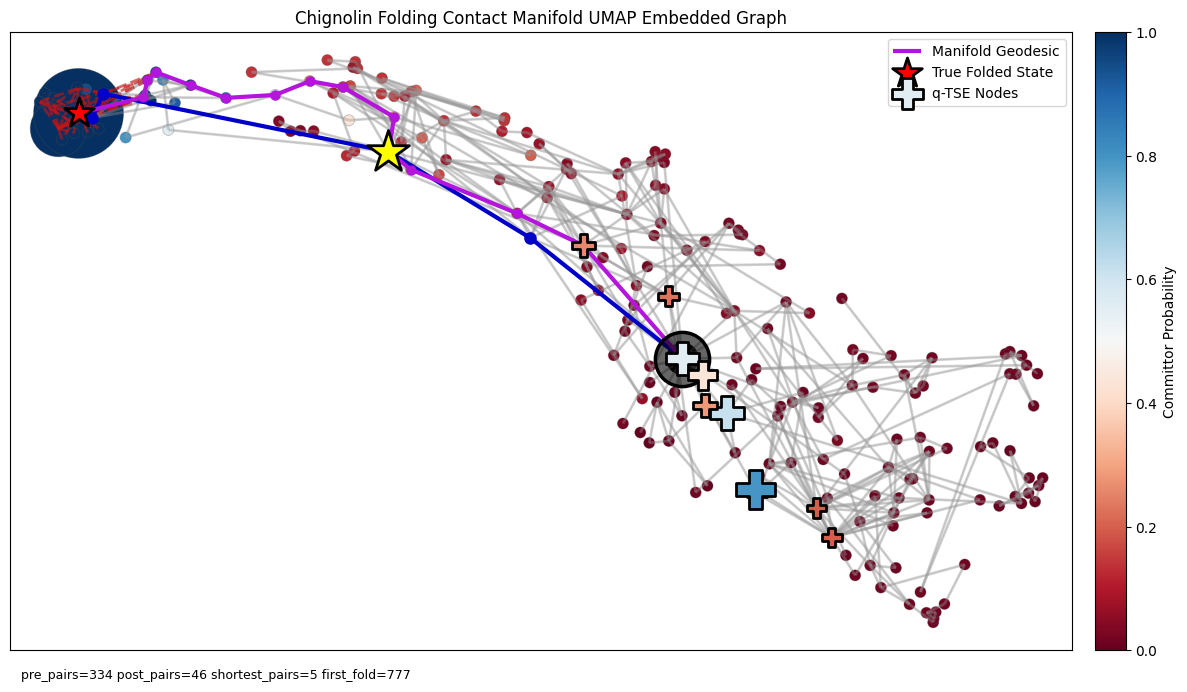

In [86]:
node_q_colors = np.array([G.nodes[i].get('committor', 0.0) for i in range(len(G.nodes()))])

fig, ax = plotting.plot_graph_auto(G, frame_to_uid, pos, X_emb, unique_maps=unique_maps, unique_indices=inds, interactive=False, count_multiplicity=False,
                                   custom_paths=custom_paths, node_custom_color=node_q_colors, palette="RdBu",
                                   node_custom_color_title="Committor Probability",
                                   title="Chignolin Folding Contact Manifold UMAP Embedded Graph")

q_tse = sorted_tse_candidates[:10]
q_tse_ids = [node_id for node_id, q_val in q_tse]
star_x = [pos[n][0] for n in range(len(q_tse))]
star_y = [pos[n][1] for n in range(len(q_tse))]

q_tse_sizes = [1000*b[1] for b in q_tse]

cmap = mpl.cm.get_cmap("RdBu")
norm = mpl.colors.Normalize(
    vmin=np.array(node_q_colors).min(),
    vmax=np.array(node_q_colors).max()
)

ax.scatter(
    star_x, 
    star_y, 
    c=np.array(node_q_colors)[q_tse_ids],        # Color
    cmap=cmap,
    norm=norm,
    marker='P',     # Star shape
    s=q_tse_sizes,          # Size (make it visible)
    edgecolors='black', # Optional: black outline for contrast
    linewidths=2,
    label='q-TSE Nodes',
    zorder=20,
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='upper right')

ax.scatter(
    pos[117][0], 
    pos[117][1], 
    c="yellow", 
    marker='*',     # Star shape
    s=1000,          # Size (make it visible)
    edgecolors='black', # Optional: black outline for contrast
    linewidths=2,
    zorder=21,
)

plt.savefig("images/chignolin_manifold_umap_graph_qtse_seqsep.png")

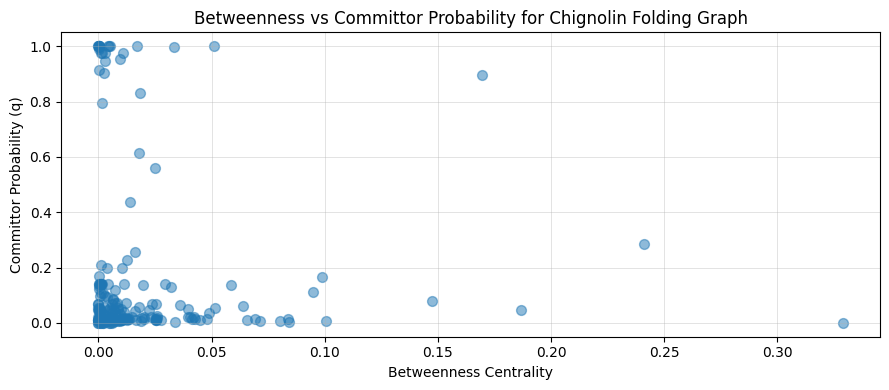

In [210]:
plt.figure(figsize=(9,4))
plt.scatter(list(betweenness.values()), list(q_map.values()), s=50, alpha=0.5)
plt.grid(
    True,
    which='both',      # 'major', 'minor', or 'both'
    linestyle='-',
    linewidth=0.5,
    alpha=0.5
)
plt.xlabel("Betweenness Centrality")
plt.ylabel("Committor Probability (q)")
plt.title("Betweenness vs Committor Probability for Chignolin Folding Graph")

plt.tight_layout() 
plt.savefig("images/chignolin_betweenness_vs_committor.png")

ERROR: No path between 2 12
ERROR: No path between 2 13
ERROR: No path between 4 171
ERROR: No path between 11 12
ERROR: No path between 13 14
ERROR: No path between 14 16
ERROR: No path between 16 18
ERROR: No path between 17 24
ERROR: No path between 18 19
ERROR: No path between 19 20
ERROR: No path between 20 21
ERROR: No path between 21 22
ERROR: No path between 24 25
ERROR: No path between 25 26
ERROR: No path between 41 46
ERROR: No path between 45 51
ERROR: No path between 46 47
ERROR: No path between 48 50
ERROR: No path between 71 72
ERROR: No path between 72 73
ERROR: No path between 73 74
ERROR: No path between 92 174
ERROR: No path between 112 142
ERROR: No path between 113 130
ERROR: No path between 116 168
ERROR: No path between 117 187
ERROR: No path between 122 175
ERROR: No path between 124 125
ERROR: No path between 125 126
ERROR: No path between 127 128
ERROR: No path between 128 129
ERROR: No path between 130 131
ERROR: No path between 131 132
ERROR: No path between

(array([ 3., 11., 40., 28., 63., 37., 40., 18.,  3.,  8.,  6., 10.,  4.,
         3.,  0.,  3.,  0.,  0.,  0.,  2.]),
 array([-1.06806782, -0.80874155, -0.54941528, -0.29008901, -0.03076274,
         0.22856353,  0.4878898 ,  0.74721607,  1.00654234,  1.26586861,
         1.52519488,  1.78452115,  2.04384742,  2.30317369,  2.56249996,
         2.82182623,  3.0811525 ,  3.34047877,  3.59980504,  3.85913131,
         4.11845758]),
 <BarContainer object of 20 artists>)

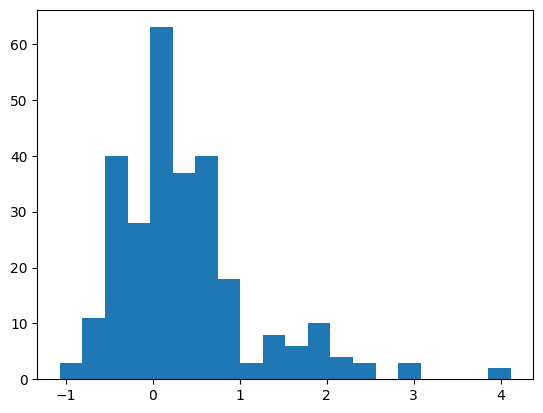

In [26]:
def infer_manifold_flux_and_energies(G, Gm=None, T=300, baseline_energy=-3.0):
    kB = 0.001987
    beta = 1.0 / (kB * T)
    
    # Initialize attributes
    for u in G.nodes():
        G.nodes[u]['throughput'] = 0.0  # NEW: Tracks "Traffic" without affecting Stability
    for u, v in G.edges():
        G[u][v]['inferred_flux'] = 0.0

    # Project Temporal Flux
    temporal_edges = [(u, v, d) for u, v, d in G.edges(data=True) if 'temp_count' in d]
    
    # Create a view of the manifold edges only (Hamming=1) for pathfinding
    # We assume edges without 'count' are the structural manifold edges
    if Gm:
        manifold_edges = Gm.edges()
    else:
        manifold_edges = [(u, v) for u, v, d in G.edges(data=True) if d['manifold']]
        Gm = G.edge_subgraph(manifold_edges)
    
    for u, v, data in temporal_edges:
        count = data.get('temp_count', 0)
        if count > 0 and u != v:
            try:
                paths = list(nx.all_shortest_paths(Gm, u, v))
                flux_per_path = count / len(paths)
                
                for path in paths:
                    # 1. Add Flux to EDGES (for Energy calculation)
                    for k in range(len(path)-1):
                        n1, n2 = path[k], path[k+1]
                        if G.has_edge(n1, n2):
                            G[n1][n2]['inferred_flux'] += flux_per_path
                        else: print("WARNING: Edge missing in G:", n1, n2)
                            
                    # 2. Add Throughput to INTERMEDIATE NODES (for Analysis only)
                    # We skip the start (u) and end (v) as they have real population
                    for node in path[1:-1]:
                        G.nodes[node]['throughput'] += flux_per_path
                        
            except nx.NetworkXNoPath:
                print("ERROR: No path between", u, v)
                continue

    # Calculate Energies (Using Population, IGNORING Throughput for stability)
    for u, v, data in G.edges(data=True):
        if 'inferred_flux' in data:
            flux = data['inferred_flux']
            pop_u = G.nodes[u].get('frame_count', 0)
            
            # CASE 1: Stable Source
            if pop_u > 0:
                rate = flux / pop_u
                if rate > 0:
                    data['energy_cost'] = -np.log(rate) / beta
                else:
                    data['energy_cost'] = np.nan
            
            # CASE 2: Transient Source (The "Ghost Node")
            # We see flux, but no population. 
            # This confirms it's a Transition State.
            elif pop_u == 0 and flux > 0:
                # Assign minimal energy (fastest possible rate)
                data['energy_cost'] = baseline_energy 
                data['type'] = 'cooperative_slide'

    return G

Genergy = infer_manifold_flux_and_energies(G, Gm, T=300)

costs = []
for u, v, data in Genergy.edges(data=True):
    costs.append(data["energy_cost"])

plt.hist(costs, bins=20)

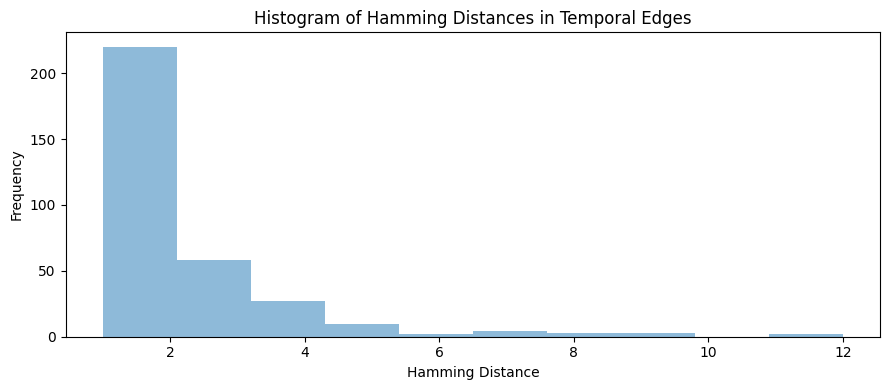

In [207]:
'''  
Histogram of hamming distances in temporal edges
'''

temporal_edges = [(u, v, d) for u, v, d in G.edges(data=True) if 'temp_count' in d]

# Create a view of the manifold edges only (Hamming=1) for pathfinding
# We assume edges without 'count' are the structural manifold edges
if Gm:
    manifold_edges = Gm.edges()
else:
    manifold_edges = [(u, v) for u, v, d in G.edges(data=True) if d['manifold']]
    Gm = G.edge_subgraph(manifold_edges)

hamming_distances = []
for u, v, data in temporal_edges:
    count = data.get('temp_count', 0)
    if count > 0 and u != v:
        try:
            path = nx.shortest_path(Gm, u, v)
            hamming_distance = len(path) - 1
            hamming_distances.append(hamming_distance)
                    
        except nx.NetworkXNoPath:
            continue

plt.figure(figsize=(9,4))
plt.title("Histogram of Hamming Distances in Temporal Edges")
plt.ylabel("Frequency")
plt.xlabel("Hamming Distance")
plt.hist(hamming_distances, bins=10, alpha=0.5)

plt.tight_layout() 
plt.savefig("images/chignolin_hamming_distance_histogram.png")

In [ ]:
G_energy, df, results = contact_energies.infer_contact_flip_energies_from_graph(G, ints=ints, node_state_attr=G.nodes, Gm=Gm)
df

,residue_pair,res_label,C_inf,N_adj,p_flip,k_flip_1_per_ps,dG_rel_kcal_per_mol,n_edges_contexts
0,"(3, 8)",3-8,64.000000,9347.0,0.006847,0.000034,3.149980,19
1,"(1, 6)",1-6,89.000000,9135.0,0.009743,0.000049,2.938848,12
2,"(0, 7)",0-7,147.000000,4113.0,0.035740,0.000182,2.156084,12
3,"(3, 7)",3-7,441.272727,9305.0,0.047423,0.000243,1.983863,39
4,"(0, 4)",0-4,28.000000,315.0,0.088889,0.000465,1.596199,13
5,"(5, 9)",5-9,53.000000,348.0,0.152299,0.000826,1.254152,18
6,"(4, 8)",4-8,47.000000,274.0,0.171533,0.000941,1.176611,12
7,"(2, 6)",2-6,53.000000,281.0,0.188612,0.001045,1.114020,12
8,"(0, 9)",0-9,13.000000,65.0,0.200000,0.001116,1.075009,7
9,"(1, 9)",1-9,23.000000,102.0,0.225490,0.001278,0.994226,11


In [105]:
'''
DESRES Q-value function
'''

import mdtraj as md
import numpy as np

def identify_native_contacts(folded_traj_or_struct, 
                             selection="name CA", 
                             min_seq_sep=3, 
                             threshold_dist_nm=0.8, 
                             occupancy_threshold=0.80):
    """
    Identifies native contacts based on the protocol:
    "Contacts between residues separated by at least 7 residues... 
    closer than 10 A (1.0 nm) for more than 80% of the time in the folded state."
    
    Parameters:
    -----------
    folded_traj_or_struct : mdtraj.Trajectory
        A trajectory of the 'folded state' (e.g., the most populated cluster) 
        OR a single native PDB structure.
    selection : str
        Atom selection query (default: C-alpha).
    min_seq_sep : int
        Minimum residue sequence separation (|i-j| >= 7).
    threshold_dist_nm : float
        Distance cutoff in nanometers (10 Angstroms = 1.0 nm).
    occupancy_threshold : float
        Fraction of frames the contact must be present (0.80). 
        If a single structure is provided, this is ignored (assumed 1.0).

    Returns:
    --------
    native_pairs : np.ndarray
        Array of shape (N, 2) containing atom indices of native contacts.
    native_dists : np.ndarray
        Array of shape (N,) containing the reference distances (r0) for these pairs.
    """
    
    # 1. Select Atoms (C-alpha)
    atom_indices = folded_traj_or_struct.topology.select(selection)
    
    # 2. Create all possible pairs satisfying sequence separation
    pairs = []
    # Map atom index back to residue index to check sequence separation
    atom_to_res = {
        atom.index: atom.residue.index 
        for atom in folded_traj_or_struct.topology.atoms 
        if atom.index in atom_indices
    }
    
    sorted_indices = sorted(list(atom_indices))
    for i in range(len(sorted_indices)):
        for j in range(i + 1, len(sorted_indices)):
            idx_i = sorted_indices[i]
            idx_j = sorted_indices[j]
            
            res_i = atom_to_res[idx_i]
            res_j = atom_to_res[idx_j]
            
            if abs(res_i - res_j) >= min_seq_sep:
                pairs.append([idx_i, idx_j])
                
    if not pairs:
        raise ValueError("No pairs found satisfying sequence separation criteria.")
        
    pairs = np.array(pairs)

    # 3. Compute distances across the provided folded trajectory/structure
    # Result shape: (n_frames, n_pairs)
    dists = md.compute_distances(folded_traj_or_struct, pairs)

    # 4. Filter by Occupancy (10 Angstroms rule)
    # Check how often dist < 1.0 nm
    is_contact = dists < threshold_dist_nm
    occupancy = np.mean(is_contact, axis=0)
    
    # Keep pairs where occupancy > 80%
    # If it's a single structure, occupancy will be 0 or 1.
    keep_mask = occupancy > occupancy_threshold
    
    native_pairs = pairs[keep_mask]
    
    # Define r0 (native distance) as the average distance in the folded ensemble
    # or the static distance if a single PDB is used.
    native_dists = np.mean(dists[:, keep_mask], axis=0)
    
    print(f"Identified {len(native_pairs)} native contacts from {len(pairs)} candidates.")
    return native_pairs, native_dists

def compute_Q(traj, native_pairs, native_dists_r0, beta=50.0, lambda_const=1.2):
    """
    Calculates the reaction coordinate Q(t) for a trajectory.
    
    Formula: Q(t) = (1/N) * Sum( 1 / (1 + exp(beta * (r(t) - lambda * r0))) )
    
    Parameters:
    -----------
    traj : mdtraj.Trajectory
        The simulation trajectory to analyze.
    native_pairs : np.ndarray
        Indices of native contacts (from identify_native_contacts).
    native_dists_r0 : np.ndarray
        Reference distances (r0) for the native pairs.
    beta : float
        Smoothing parameter in nm^-1. Default 50 nm^-1 (approx 5 Angstrom^-1).
    lambda_const : float
        Tolerance factor. Default 1.2. 
        (Contact is 'formed' if dist is within ~1.2x of native dist).

    Returns:
    --------
    Q : np.ndarray
        Array of Q values for each frame in the trajectory (0.0 to 1.0).
    """
    
    if len(native_pairs) == 0:
        return np.zeros(traj.n_frames)

    # 1. Compute distances for the native pairs in the new trajectory
    # Shape: (n_frames, n_contacts)
    r_t = md.compute_distances(traj, native_pairs)
    
    # 2. Calculate the sigmoid argument: beta * (r(t) - lambda * r0)
    # native_dists_r0 must be broadcasted to match n_frames
    val = beta * (r_t - lambda_const * native_dists_r0)
    
    # 3. Apply Sigmoid
    # Q_ij = 1 / (1 + exp(val))
    Q_ij = 1.0 / (1.0 + np.exp(val))
    
    # 4. Average over all contacts for each frame
    Q_t = np.mean(Q_ij, axis=1)
    
    return Q_t

native_struct = md.load("/Users/kebl8116-admin/Projects/origami/data/Chignolin/5awl.pdb")
        
# 2. Identify Contacts
# Note: If you have a trajectory of the folded state, pass that instead of 'native_struct'
# to strictly adhere to the " > 80% time" rule.
pairs, r0 = identify_native_contacts(native_struct)

# 3. Load Simulation Trajectory
pdb = "/Users/kebl8116-admin/Projects/origami/data/Chignolin/xtc/nvt_prod_1_protein.pdb"
xtc = "/Users/kebl8116-admin/Projects/origami/data/Chignolin/xtc/nvt_prod_1_protein.xtc"
traj = md.load(xtc, top=pdb)

# 4. Calculate Q
q_values = compute_Q(traj, pairs, r0)

print(f"Computed Q for {traj.n_frames} frames.")
print(f"Mean Q: {np.mean(q_values):.4f}")


Identified 12 native contacts from 28 candidates.
Computed Q for 10001 frames.
Mean Q: 0.7818


/var/folders/bd/1_0prvlx06lcc135mt668_3r0000gs/T/ipykernel_8329/135618178.py:131: RuntimeWarning: overflow encountered in exp
  Q_ij = 1.0 / (1.0 + np.exp(val))


In [ ]:
import numpy as np
from collections import OrderedDict

def parse_pdb_ca(pdb_path, keep_het=False):
    """
    Parse PDB and return OrderedDict mapping residue_key -> dict with:
      - chain, resname, resseq, icode
      - ca: (x,y,z) of the C-alpha atom (or None if missing)
    Only ATOM records are considered for CA coordinates (HETATM ignored unless keep_het=True).
    Residues keep file order.
    """
    residues = OrderedDict()
    with open(pdb_path, 'r') as fh:
        for ln in fh:
            if not ln.startswith(('ATOM  ', 'HETATM')):
                continue
            is_het = ln.startswith('HETATM')
            if is_het and not keep_het:
                continue
            atom_name = ln[12:16].strip()
            if atom_name != 'CA':
                # we only need CA coords; still ensure residue entry exists for ordering
                chain = ln[21].strip() or '_'
                try:
                    resseq = int(ln[22:26])
                except ValueError:
                    resseq = int(ln[22:26].strip() or 0)
                icode = ln[26].strip() or ' '
                resname = ln[17:20].strip()
                key = (chain, resseq, icode, resname)
                if key not in residues:
                    residues[key] = {'chain': chain, 'resname': resname,
                                     'resseq': resseq, 'icode': icode,
                                     'ca': None}
                continue
            # atom is CA
            chain = ln[21].strip() or '_'
            try:
                resseq = int(ln[22:26])
            except ValueError:
                resseq = int(ln[22:26].strip() or 0)
            icode = ln[26].strip() or ' '
            resname = ln[17:20].strip()
            try:
                x = float(ln[30:38]); y = float(ln[38:46]); z = float(ln[46:54])
            except ValueError:
                # skip malformed coordinate lines
                continue
            key = (chain, resseq, icode, resname)
            if key not in residues:
                residues[key] = {'chain': chain, 'resname': resname,
                                 'resseq': resseq, 'icode': icode,
                                 'ca': (x,y,z)}
            else:
                residues[key]['ca'] = (x,y,z)
    return residues

def assign_indices_per_chain_from_ca(residues_od):
    """
    From OrderedDict of residues (from parse_pdb_ca), return list of residues that HAVE a CA,
    each with assigned 0-based index per chain, preserving file order.
    Output item: {'chain','resname','index','resseq','icode','ca': np.array([x,y,z])}
    """
    out = []
    chain_counters = {}
    for key, info in residues_od.items():
        if info['ca'] is None:
            # skip residues without CA
            continue
        chain = info['chain']
        idx = chain_counters.get(chain, 0)
        out.append({'chain': chain,
                    'resname': info['resname'],
                    'index': idx,
                    'resseq': info['resseq'],
                    'icode': info['icode'],
                    'ca': np.asarray(info['ca'], dtype=float)})
        chain_counters[chain] = idx + 1
    return out

def ca_ca_contacts(
    pdb_path,
    cutoff=8.0,
    keep_het=False,
    min_seq_sep=0,
    require_different_chains=False,
    return_distance=True,
    return_with_chain=True
):
    """
    Compute CA-CA contacting residue pairs.

    Parameters
    ----------
    pdb_path : str
        Path to PDB file.
    cutoff : float
        Distance cutoff in Angstroms (default 8.0 Å — adjust as desired).
    keep_het : bool
        Include HETATM CA atoms (default False).
    min_seq_sep : int
        Minimum sequence separation (in 0-based index units) along SAME CHAIN to consider a contact.
        Example: min_seq_sep=1 excludes i--i+1 contacts. Default 0 (no exclusion).
    require_different_chains : bool
        If True, only return inter-chain contacts.
    return_distance : bool
        If True, include the CA-CA distance in the returned tuple.
    return_with_chain : bool
        If True, return tuples (resA, idxA, chainA, resB, idxB, chainB[, dist]).
        If False, omit chain IDs.

    Returns
    -------
    contacts : list of tuples
        Each tuple is a contacting residue pair. Pairs are ordered by appearance (i<j).
    """
    residues_od = parse_pdb_ca(pdb_path, keep_het=keep_het)
    residues = assign_indices_per_chain_from_ca(residues_od)
    n = len(residues)
    cutoff2 = float(cutoff) ** 2
    contacts = []
    for i in range(n):
        ai = residues[i]
        A = ai['ca']  # shape (3,)
        for j in range(i+1, n):
            bj = residues[j]
            # chain filters / sequence separation
            if require_different_chains and (ai['chain'] == bj['chain']):
                continue
            if ai['chain'] == bj['chain']:
                if abs(ai['index'] - bj['index']) <= min_seq_sep:
                    continue
            B = bj['ca']
            d2 = np.sum((A - B)**2)
            if d2 <= cutoff2:
                dist = float(np.sqrt(d2))
                if return_with_chain:
                    if return_distance:
                        contacts.append((ai['resname'], ai['index'], ai['chain'],
                                         bj['resname'], bj['index'], bj['chain'],
                                         round(dist, 3)))
                    else:
                        contacts.append((ai['resname'], ai['index'], ai['chain'],
                                         bj['resname'], bj['index'], bj['chain']))
                else:
                    if return_distance:
                        contacts.append((ai['resname'], ai['index'],
                                         bj['resname'], bj['index'],
                                         round(dist, 3)))
                    else:
                        contacts.append((ai['resname'], ai['index'],
                                         bj['resname'], bj['index']))
    return contacts

pairs_dist = ca_ca_contacts(pdb, cutoff=8.0, min_seq_sep=3, require_different_chains=False)
for p in pairs_dist:
    # when return_with_chain=True and return_distance=True:
    # p == (resA, idxA, chainA, resB, idxB, chainB, dist)
    print(f"{p[0]}{p[1]}({p[2]})  --  {p[3]}{p[4]}({p[5]})  dist={p[6]:.3f} Å")


TYR0(X)  --  TRP8(X)  dist=5.186 Å
TYR0(X)  --  TYR9(X)  dist=5.213 Å
TYR1(X)  --  GLY6(X)  dist=7.210 Å
TYR1(X)  --  THR7(X)  dist=5.799 Å
TYR1(X)  --  TRP8(X)  dist=4.337 Å
TYR1(X)  --  TYR9(X)  dist=6.905 Å
ASP2(X)  --  GLY6(X)  dist=5.507 Å
ASP2(X)  --  THR7(X)  dist=5.361 Å
ASP2(X)  --  TRP8(X)  dist=6.345 Å
PRO3(X)  --  THR7(X)  dist=7.919 Å


In [108]:
import mdtraj as md
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def compute_contact_matrix(traj, native_pairs, native_dists_r0, beta=50.0, lambda_const=1.2):
    """
    Computes the individual q_ij values for every contact at every frame.
    
    Returns:
    --------
    q_matrix : np.ndarray
        Shape (n_frames, n_contacts). Values between 0.0 and 1.0.
    """
    # 1. Compute distances for the native pairs
    r_t = md.compute_distances(traj, native_pairs)
    
    # 2. Calculate Sigmoid for each contact individually
    # val shape: (n_frames, n_contacts)
    val = beta * (r_t - lambda_const * native_dists_r0)
    q_matrix = 1.0 / (1.0 + np.exp(val))
    
    return q_matrix

def analyze_contributions(q_matrix, native_pairs, traj_topology):
    """
    Converts the raw matrix into a readable DataFrame describing which 
    residues are involved in the most stable contacts.
    """
    # 1. Calculate Stability (Mean occupancy of each contact)
    # Average over all frames provided
    stability = np.mean(q_matrix, axis=0)
    
    # 2. Map back to residue names for readability
    data = []
    for k, (atom_i, atom_j) in enumerate(native_pairs):
        res_i = traj_topology.atom(atom_i).residue
        res_j = traj_topology.atom(atom_j).residue
        
        data.append({
            #'Contact_ID': k,
            # 'Residue_A': f"{res_i.name}{res_i.index}",
            # 'Residue_B': f"{res_j.name}{res_j.index}",
            # 'Seq_Separation': abs(res_i.index - res_j.index),
            "residue pair": f"{res_i.name}{res_i.index}, {res_j.name}{res_j.index}",
            'stability': stability[k] # 0.0 to 1.0
        })
        
    df = pd.DataFrame(data)
    
    # Sort by stability (most stable first)
    df_sorted = df.sort_values(by='stability', ascending=False).reset_index(drop=True)
    
    return df_sorted

# --- Example Usage ---
# Assuming 'traj', 'pairs', and 'r0' are defined from previous steps
q_matrix = compute_contact_matrix(traj, pairs, r0)
df_contacts = analyze_contributions(q_matrix, pairs, traj.topology)

tablefmt = "github"
print(df_contacts.to_markdown(tablefmt=tablefmt))

|    | residue pair   |   stability |
|----|----------------|-------------|
|  0 | ASP2, TRP8     |   0.927066  |
|  1 | TYR0, TYR9     |   0.923661  |
|  2 | TYR1, TYR9     |   0.923486  |
|  3 | ASP2, THR7     |   0.918041  |
|  4 | ASP2, THR5     |   0.910078  |
|  5 | TYR1, TRP8     |   0.895284  |
|  6 | TYR0, TRP8     |   0.866649  |
|  7 | TYR1, THR7     |   0.801856  |
|  8 | ASP2, GLY6     |   0.75156   |
|  9 | PRO3, GLY6     |   0.688705  |
| 10 | ASP2, TYR9     |   0.687265  |
| 11 | TYR1, GLY6     |   0.0880556 |


/var/folders/bd/1_0prvlx06lcc135mt668_3r0000gs/T/ipykernel_8329/2081735194.py:22: RuntimeWarning: overflow encountered in exp
  q_matrix = 1.0 / (1.0 + np.exp(val))


In [111]:
import numpy as np
from math import isclose, sqrt

def n_bits_for_N(N):
    return N * (N - 1) // 2

def infer_N_from_bits(n_bits):
    # solve N(N-1)/2 = n_bits  -> N^2 - N - 2*n_bits = 0
    N = int((1 + sqrt(1 + 8 * n_bits)) / 2)
    if n_bits_for_N(N) != n_bits:
        raise ValueError("n_bits is not a triangular number")
    return N

def upper_bits_to_full_matrix(bits, N=None):
    """
    bits: 1D iterable/array of 0/1 of length M = N(N-1)/2 (row-major upper triangle)
          bits[k] corresponds to pair (i,j) produced by scanning rows:
            (0,1),(0,2),...,(0,N-1),(1,2),(1,3),...,(N-2,N-1)
    N: number of residues (optional if bits length gives N)
    Returns: (N,N) numpy array, dtype=int (0/1), symmetric, diagonal 0.
    """
    bits = np.asarray(bits, dtype=int).ravel()
    M = bits.size
    if N is None:
        N = infer_N_from_bits(M)
    else:
        if n_bits_for_N(N) != M:
            raise ValueError("Length of bits does not match provided N")

    mat = np.zeros((N, N), dtype=int)

    # Build row/col lists for the strict upper triangle in the same row-major order
    rows = []
    cols = []
    for i in range(N):
        for j in range(i + 1, N):
            rows.append(i)
            cols.append(j)
    rows = np.array(rows, dtype=int)
    cols = np.array(cols, dtype=int)

    # assign bits
    mat[rows, cols] = bits
    mat[cols, rows] = bits  # symmetric
    return mat

def int_to_contact_matrix(x, N=None, n_bits=None, lsb_first=True):
    """
    x: integer encoding the upper-triangle bits
    N: number of residues (optional)
    n_bits: explicit number of upper-triangle bits (optional). If provided, overrides infer from N.
    lsb_first: if True (default), bit_index 0 is the least-significant bit of x.
               If False, bit_index 0 is the most-significant bit of the n_bits-length representation.
    Returns: (N,N) numpy int matrix symmetric.
    """
    if n_bits is None:
        if N is None:
            raise ValueError("Provide N or n_bits")
        n_bits = n_bits_for_N(N)
    else:
        # infer N if not given
        if N is None:
            N = infer_N_from_bits(n_bits)

    # extract bits into length-n_bits array in flattened row-major order
    # bit k corresponds to flattened index k.
    bits = np.zeros(n_bits, dtype=int)
    if lsb_first:
        # bit 0 is LSB
        for k in range(n_bits):
            bits[k] = (x >> k) & 1
    else:
        # MSB-first: map flattened index k -> integer bit at position (n_bits-1-k)
        for k in range(n_bits):
            bits[k] = (x >> (n_bits - 1 - k)) & 1

    return upper_bits_to_full_matrix(bits, N=N)

import seaborn as sns 

N = 10
M = n_bits_for_N(N)  # 45
# set bit 22 (flattened index 22) using LSB-first integer

res_pairs_native = []
for pair in df_contacts['residue pair']: 
    r1, r2 = pair.split(', ')
    idx1 = int(r1[-1])
    idx2 = int(r2[-1])
    res_pairs_native.append( (idx1, idx2) )
    
print(res_pairs_native)

[(2, 8), (0, 9), (1, 9), (2, 7), (2, 5), (1, 8), (0, 8), (1, 7), (2, 6), (3, 6), (2, 9), (1, 6)]


(2, 5) not found in df_contacts
(3, 6) not found in df_contacts


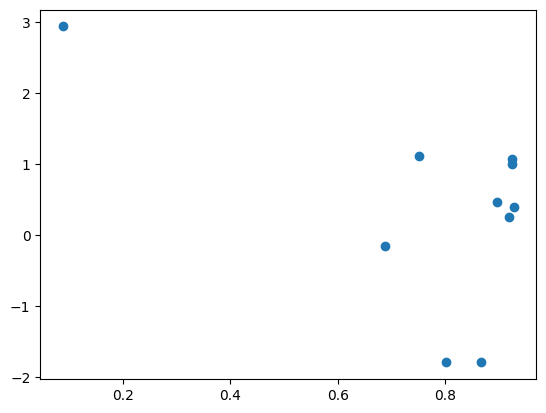

In [134]:
contact_energy_natives = {}
for res_pair in res_pairs_native:
    try:
        contact_energy_natives[res_pair] = df.loc[df['residue_pair'] == res_pair, 'dG_rel_kcal_per_mol'].iloc[0]
    except: 
        print(res_pair, "not found in df_contacts")
        contact_energy_natives[res_pair] = np.nan
         
df_contacts['dG_rel_kcal_per_mol'] = contact_energy_natives.values()
plt.scatter(df_contacts['stability'], df_contacts['dG_rel_kcal_per_mol'])

(2, 5) not found in df_contacts
(3, 6) not found in df_contacts


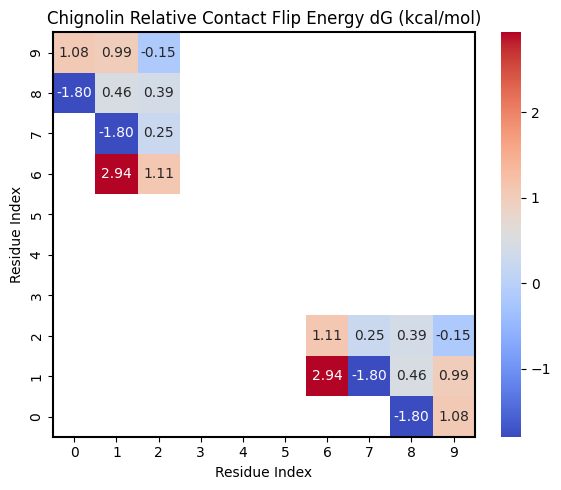

In [172]:
contact_energies_matrix = np.full((N,N), np.nan, dtype=float)
for native_pair in res_pairs_native:
    i, j = native_pair
    try:
        contact_energies_matrix[i, j] = df.loc[df['residue_pair'] == native_pair, 'dG_rel_kcal_per_mol'].iloc[0]
        contact_energies_matrix[j, i] = df.loc[df['residue_pair'] == native_pair, 'dG_rel_kcal_per_mol'].iloc[0]
    except:
        print(native_pair, "not found in df_contacts")
        contact_energies_matrix[i, j] = np.nan
        contact_energies_matrix[j, i] = np.nan

import seaborn as sns
plt.figure(figsize=(6, 5))
ax = sns.heatmap(contact_energies_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0,
    cbar=True
)
ax.invert_yaxis()

# Turn ON only the outer axes box
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color("black")
    spine.set_linewidth(1.5)

plt.title("Chignolin Relative Contact Flip Energy dG (kcal/mol)")
plt.ylabel("Residue Index")
plt.xlabel("Residue Index")
plt.tight_layout()
plt.savefig("images/chignolin_contact_flip_energy_matrix.png")
plt.show()

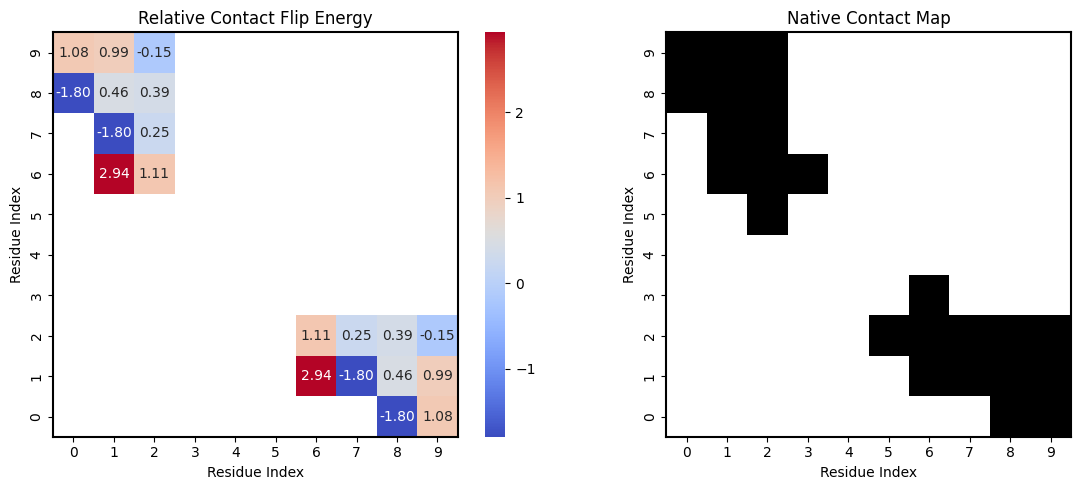

In [174]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# --- Heatmap 1: contact energies ---
sns.heatmap(
    contact_energies_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0,
    cbar=True,
    ax=ax[0]
)

ax[0].invert_yaxis()

# Outer axes box only
for spine in ax[0].spines.values():
    spine.set_visible(True)
    spine.set_color("black")
    spine.set_linewidth(1.5)

ax[0].set_title("Relative Contact Flip Energy")
ax[0].set_xlabel("Residue Index")
ax[0].set_ylabel("Residue Index")

# --- Heatmap 2: native contact map ---
contact_map_native = np.zeros((N, N), dtype=int)
for i, j in res_pairs_native:
    contact_map_native[i, j] = 1
    contact_map_native[j, i] = 1

sns.heatmap(
    contact_map_native,
    annot=False,
    cmap="Greys",
    linewidths=0,
    cbar=False,
    ax=ax[1]
)

ax[1].invert_yaxis()

for spine in ax[1].spines.values():
    spine.set_visible(True)
    spine.set_color("black")
    spine.set_linewidth(1.5)

ax[1].set_title("Native Contact Map")
ax[1].set_xlabel("Residue Index")
ax[1].set_ylabel("Residue Index")

ax[0].set_aspect('equal', adjustable='box')
ax[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig("images/chignolin_contact_flip_energy_matrix_dual.png")
plt.show()


In [187]:
import numpy as np
import pandas as pd

def tse_contact_flips_dataframe(
    G,
    tse_nodes,
    ints,
    df_contact_energies,
    *,
    n_res=10,
    edge_energy_attr="energy_cost",
    node_pop_attr="frame_count",
    use_only_neighbors_in_graph=True
):
    """
    For each TSE node, find single-contact flips on incident edges, decode to residue pair,
    and join against df_contact_energies to attach per-contact energy.

    Parameters
    ----------
    G : networkx Graph/DiGraph
        Graph containing edges with per-edge energy attribute (edge_energy_attr).
    tse_nodes : list
        Node IDs belonging to TSE.
    ints : list/array-like
        ints[u] gives bitmask state for node u.
    df_contact_energies : pd.DataFrame
        Must contain either:
          - 'contact_index' (bit index) and 'manifold_flip_energy' or 'contact_flip_energy'
        and/or
          - 'residue_pair' and an energy column.
    n_res : int
        Number of residues, used to decode bit index -> residue pair.
    edge_energy_attr : str
        Edge attribute name to read edge-level energy from (e.g. 'energy_cost' or 'dG_rel').
    node_pop_attr : str
        Optional, included for context (source node occupancy).
    """

    # --- Build lookup from df_contact_energies ---
    # Try to infer the energy column name
    possible_energy_cols = [
        "manifold_flip_energy", "contact_flip_energy", "dG_rel", "energy_cost", "dG_rel_kcal_per_mol",
    ]
    energy_col = next((c for c in possible_energy_cols if c in df_contact_energies.columns), None)
    if energy_col is None:
        raise ValueError(f"df_contact_energies must contain one of {possible_energy_cols}")

    lookup_by_bit = None
    lookup_by_pair = None

    if "contact_index" in df_contact_energies.columns:
        lookup_by_bit = dict(zip(df_contact_energies["contact_index"], df_contact_energies[energy_col]))
    if "residue_pair" in df_contact_energies.columns:
        lookup_by_pair = dict(zip(df_contact_energies["residue_pair"], df_contact_energies[energy_col]))
    if lookup_by_bit is None and lookup_by_pair is None:
        raise ValueError("df_contact_energies must contain 'contact_index' or 'residue_pair'")

    rows = []

    tse_set = set(tse_nodes)

    for u in tse_nodes:
        if u not in G:
            continue

        # neighbors depends on graph type; for DiGraph, this is out-neighbors by default
        nbrs = list(G.neighbors(u))

        for v in nbrs:
            if use_only_neighbors_in_graph and v not in G:
                continue

            # Decode which bit differs
            state_u = ints[u]
            state_v = ints[v]
            diff = state_u ^ state_v

            # require exactly one bit flip (Hamming distance 1)
            if diff == 0 or (diff & (diff - 1)) != 0:
                continue

            bit_index = diff.bit_length() - 1

            # Decode to residue pair
            res_i, res_j = get_residue_pair_from_bit(bit_index, n_residues=n_res)
            pair = (res_i, res_j)

            # Edge-level energy (from G)
            ed = G.get_edge_data(u, v, default={})
            edge_energy = ed.get(edge_energy_attr, np.nan)

            # Contact-level energy (from df_contact_energies)
            if lookup_by_bit is not None and bit_index in lookup_by_bit:
                contact_energy = lookup_by_bit[bit_index]
            elif lookup_by_pair is not None and pair in lookup_by_pair:
                contact_energy = lookup_by_pair[pair]
            else:
                contact_energy = np.nan

            rows.append({
                "tse_node": u,
                "neighbor": v,
                "bit_index": bit_index,
                "residue_pair": pair,
                "res_label": f"{res_i}-{res_j}",
                "edge_energy": edge_energy,
                "contact_energy": contact_energy,
                "tse_neighbor_is_tse": (v in tse_set),
                "node_pop": G.nodes[u].get(node_pop_attr, np.nan),
            })

    df = pd.DataFrame(rows)

    # Useful ordering: group by node then by increasing barrier (or whatever)
    if not df.empty:
        df = df.sort_values(["tse_node", "contact_energy", "edge_energy"], ascending=[True, True, True]).reset_index(drop=True)

    return df


df_tse_flips = tse_contact_flips_dataframe(
    G_energy,
    tse_nodes=[x[0] for x in sorted_tse_candidates[:10]],      # your list
    ints=ints,
    df_contact_energies=df,      # your df from compute_manifold_flip_energies
    n_res=N,
    edge_energy_attr="energy_cost",   # or "dG_rel" depending what you stored
)
df_tse_contacts = (
    df_tse_flips
    .dropna(subset=["contact_energy"])
    .drop_duplicates(subset=["residue_pair"])   # one row per contact
    .sort_values("contact_energy", ascending=True)
    .reset_index(drop=True)
)
df_tse_contacts

,tse_node,neighbor,bit_index,residue_pair,res_label,edge_energy,contact_energy,tse_neighbor_is_tse,node_pop
0,117,118,14,"(1, 7)",1-7,NaN,-1.797820,False,4
1,177,179,7,"(0, 8)",0-8,NaN,-1.797820,True,1
2,117,159,21,"(2, 7)",2-7,NaN,0.252085,True,4
3,117,178,15,"(1, 8)",1-8,NaN,0.464168,True,4
4,117,169,5,"(0, 6)",0-6,NaN,0.558586,False,4
5,117,116,12,"(1, 5)",1-5,NaN,0.932239,False,4
6,159,126,16,"(1, 9)",1-9,NaN,0.994226,False,2
7,179,185,8,"(0, 9)",0-9,NaN,1.075009,False,2
8,119,122,38,"(5, 9)",5-9,NaN,1.254152,False,1
9,117,127,27,"(3, 7)",3-7,NaN,1.983863,False,4


In [21]:
contact_energy_natives = {}
for res_pair in res_pairs_native:
    contact_energy_natives[res_pair] = df.loc[df['residue_pair'] == res_pair, 'manifold_flip_energy'].iloc[0]

df_contacts['manifold_flip_energy'] = contact_energy_natives.values()
df_contacts

IndexError: single positional indexer is out-of-bounds

In [135]:
plt.scatter(df_contacts["stability"], df_contacts["manifold_flip_energy"])

KeyError: 'manifold_flip_energy'